# Chapter 4 - Classification

The following exercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

Make sure the following packages are installed prior to running code in this notebook:
- `numpy`
- `pandas`
- `sklearn`
- `statsmodels`
- `ISLP`

## Exercise: The Stock Market
This exercise is adapted from Chapter 4, Exercise 13 in ISLP.

In this problem, you will develop models (logistic regression, LDA, QDA, kNN) to predict whether the stock market will go up or down based on the `Weekly` data set from the `ISLR` package.

### 1) Import Packages and Load Data
We begin by importing the packages we need:

In [3]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table

This exercise uses the `Weekly` data set, which is part of the `ISLP` package. This data is similar in nature to the `Smarket` data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

The code below loads the `Weekly` data from the ISLP package.

In [4]:
weekly = load_data('Weekly')

In [5]:
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


### 2) Visualize Data

Before plotting, let's look at the correlation between each of the numeric columns in `Weekly`. 

In [6]:
weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


The corelation between today's return (`Today`) and percentage returns for the previous five days (`Lag1-5`) are nearly zero.  The only correlation NOT near zero is between `Year` and `Volume`.  We can visualize these correlations via the following scatterplot matrix.

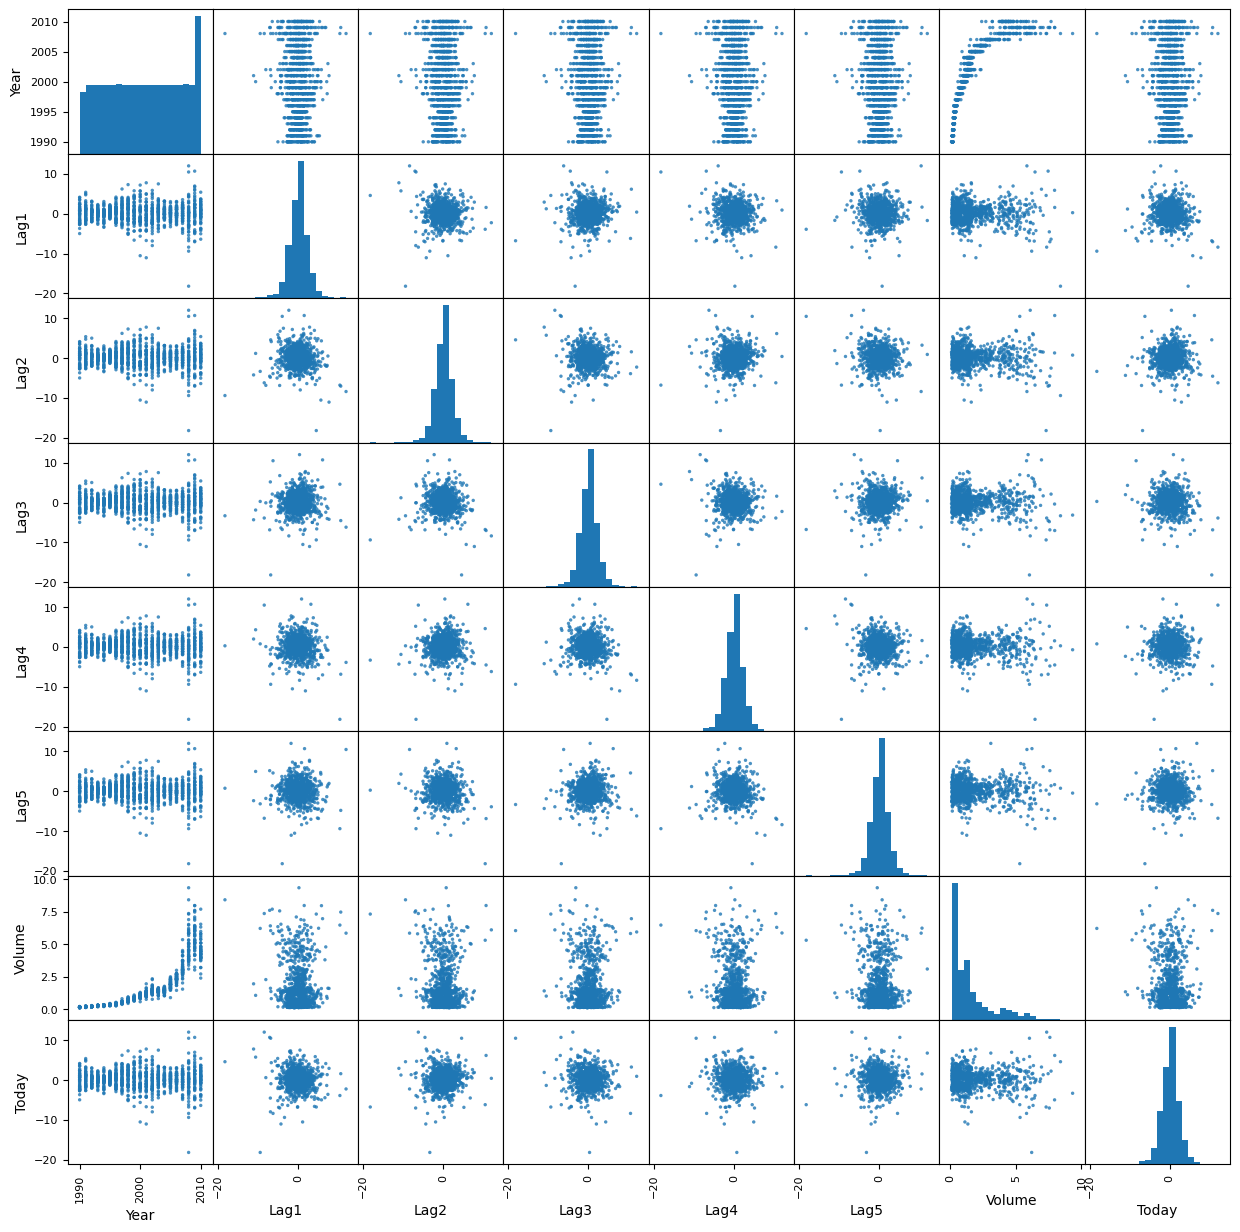

In [7]:
pd.plotting.scatter_matrix(weekly, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=6, alpha=.8,
                           range_padding=0.2);

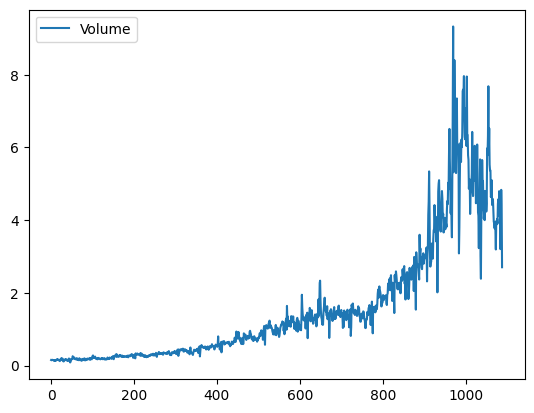

In [8]:
weekly.plot(y='Volume');

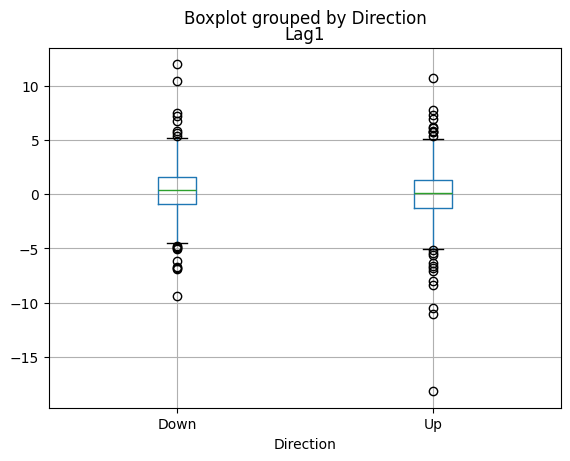

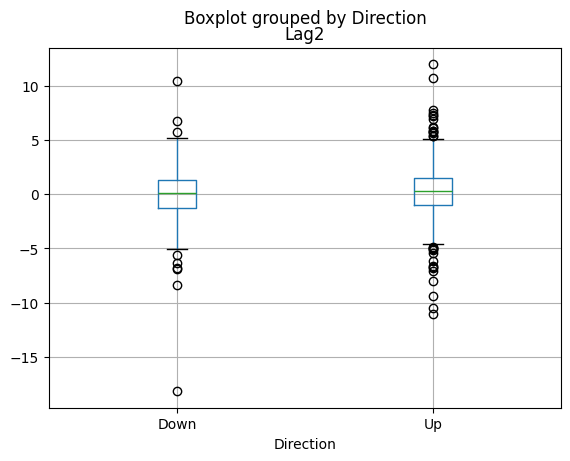

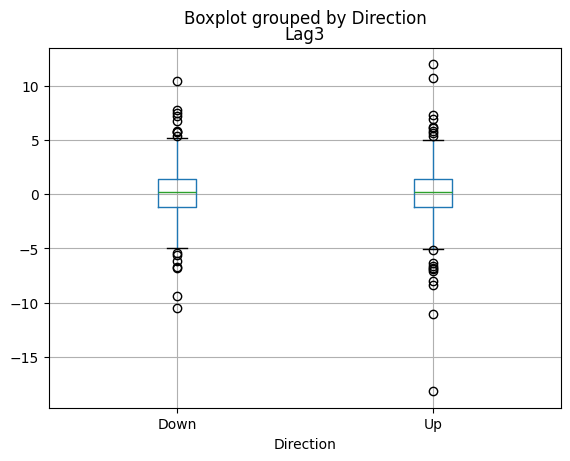

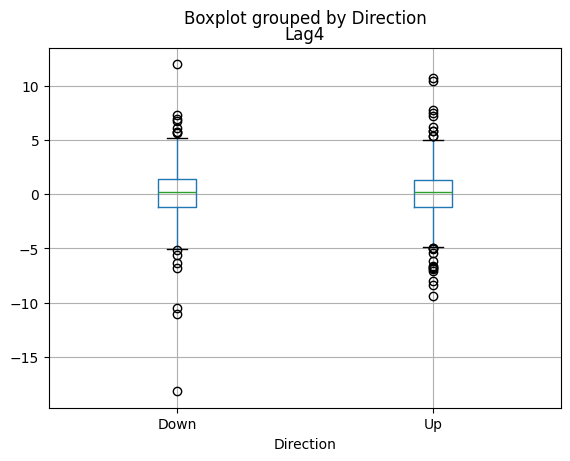

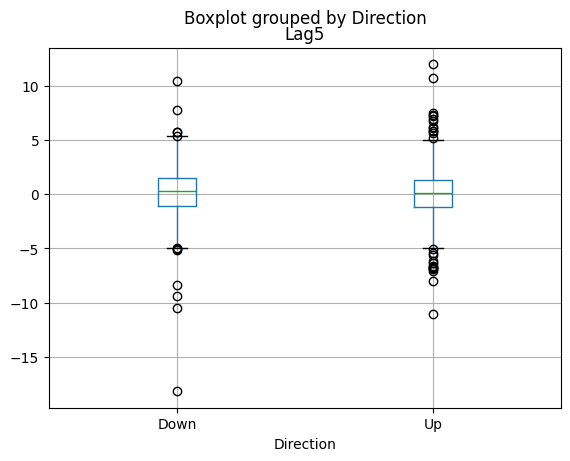

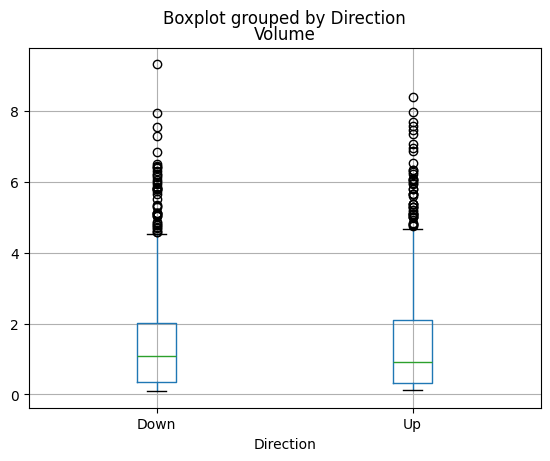

In [9]:
for i in range(1, 7):
    colName = weekly.columns[i]
    weekly.boxplot(column=colName, by="Direction")

### 3) Build Training and Test Sets
Before fitting a model, we need to split the `Weekly` data into a training and test set.  For this example, we will randomly select 85% of the data for our training set and the remaining 15% will be used as a test set.

In [10]:
weekly_train, weekly_test = train_test_split(weekly, random_state=47, test_size=0.15)

Next, we will construct `X` so we can fit a model using `Lag1` - `Lag5` and `Volume` as predictors.  To do so, we will use a general approach from the `ISLP` library that is used throughout the course.  We use `ModelSpec()` (renamed `MS()` in the preamble) that creates a transform object, and then a pair of methods `transform()` and `fit()` are used to construct a
corresponding `X`.

In this example, to get the predictor columns we want in `X`, we start by dropping the columns we don't want (`Today`, `Direction`, and `Year`) and saving this to a new variable called `allvars`.  Then we create the transform by the expression `design = MS(allvars)`.

We then apply the `fit_transform` method on the original array to produce the model matrix `X`. For now, we will not worry too much about the details of `fit_transform()`.  We do this for the training and the test set separtely.

In [11]:
allvars = weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X_train = design.fit_transform(weekly_train)
X_test = design.fit_transform(weekly_test)

To visualize what our `X` looks like, let's print `X_test`. Notice `X_test` has an intercept column followed by the predictor columns we specified.

In [12]:
X_test

,intercept,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
727,1.0,0.151,1.602,1.207,1.149,0.664,1.677675
814,1.0,-1.827,-0.288,1.926,1.072,-1.198,2.268336
655,1.0,-2.418,-2.635,1.302,2.215,5.137,1.311925
429,1.0,1.182,-1.320,1.085,-1.072,2.488,0.656184
694,1.0,2.508,3.254,-1.173,1.167,0.358,1.652340
...,...,...,...,...,...,...,...
783,1.0,-0.308,0.189,2.704,0.299,-1.406,1.487736
907,1.0,1.802,0.053,-1.980,1.674,-1.866,2.317563
631,1.0,-1.497,0.159,2.874,3.848,-1.299,1.262380
709,1.0,1.735,-0.270,1.327,1.505,0.241,1.382022


Lastly, we need to construct our `y` which will contain our reponse, in this case `Direction`. Note, for fitting Logistic Regression, we want this to be a binary response, where the outcome of interest is coded as `1` or `True` (in this case, we are interested in when the market goes up) and the alternative outcome is coded as `0` or `False`. 

In [13]:
y_train = weekly_train.Direction == 'Up'
y_test = weekly_test.Direction == 'Up'

We also create version of these `y` vectors that contain the labels `Up` and `Down` which we will use for other modeling types and model evaluation.

In [14]:
L_train = weekly_train.Direction
L_test = weekly_test.Direction 

### 4) Model Fitting, Prediction, and Evaluation

We start by fitting a full model (i.e. one that contains all potential predictors of interest) with `Lag1` - `Lag5` and `Volume` as we specified in Part 3.

We will fit four types of models: Logistic Regression, Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and K-Nearest Neighbors (kNN).  

### Fitting Full Model
##### Logistic Regression - Full model

We start by fitting a logistic regression model to predict `Direction`.  We will use the `sm.GLM()` which fits *generalized linear models*, a class of models that includes logistic regression.  Alternatively, the function `sm.Logit()` fits a logistic regression model directly. 

We pass our training data `y_train` and `Xtrain` and the argument `family=sm.families.Binomial()` in order to tell `statsmodels` to run a logistic regression rather than some other type of generalized linear model. 

Note that `sm.GLM()` does not fit the model; it specifies the model, and then `model.fit()` does the actual fitting.  

In [15]:
glm_train = sm.GLM(y_train, X_train,
                  family = sm.families.Binomial())
results = glm_train.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                  925
Model:                            GLM   Df Residuals:                      918
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -630.52
Date:                Mon, 14 Jul 2025   Deviance:                       1261.0
Time:                        11:32:07   Pearson chi2:                     926.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01322
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2576      0.093      2.769      0.006       0.075       0.440
Lag1          -0.0397      0.029     -1.358      0.174      -0.097       0.018
Lag2           0.0756      0.030      2.552      0.011       0.018       0.134
Lag3          -0.0196      0.030     -0.655      0.512      -0.078       0.039
Lag4          -0.0099      0.029     -0.345      0.730      -0.066       0.046
Lag5          -0.0296      0.029     -1.038      0.299      -0.085       0.026
Volume        -0.0359      0.040     -0.907      0.364      -0.113       0.042
==============================================================================
"""

According to the model, Lag2 was the only significant variable. But overall,
we cannot see a variable that is specially good at classifying the response.

##### Linear Discriminant Analysis (LDA)  - Full model

Next we'll perform LDA using the function `LinearDiscriminantAnalysis()`, which we have abbreviated `LDA()`.  Similar to `sm.GLM()`, `LDA()` does not fit the model, it simply specifies the model.

In [16]:
lda = LDA(store_covariance=True)

Since `LDA()` automatically adds an intercept, we should remove the column corresponding to the intercept in `X_train`. Notice when we print `X_train` below that the `intercept` column is not there.

In [17]:
X_train = X_train.drop(columns=['intercept'])
X_train

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
1013,6.967,-1.929,-2.446,-0.253,-2.640,4.785464
619,1.409,1.941,-3.041,1.655,-0.947,0.756117
864,-0.922,1.229,-0.554,2.807,-0.986,2.225772
75,1.044,1.649,0.787,-1.745,-1.188,0.186366
2,-2.576,-0.270,0.816,1.572,-3.936,0.159837
...,...,...,...,...,...,...
1047,0.991,3.097,-0.422,3.130,0.874,4.805318
848,-1.875,-2.604,1.156,-0.051,1.719,2.648372
691,1.167,0.358,3.479,0.585,2.911,1.442580
584,5.026,4.880,-2.749,1.799,-0.930,1.353580


We can also directly use the labels `L_train` rather than the Boolean vectors `y_train`.  We again use `fit()` to fit our model.

In [20]:
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


Note: You can extract the predictor means within each class, the class order, the priors, and the scalings from `lda` using `lda.means_`, `lda.classes_`, `lda.priors_`, and `lda.scalings_` respectively.

##### Quadratic Discriminant Analysis (QDA) - Full model

We will now fit a QDA model using `QuadraticDiscriminantAnalysis()` in the `sklearn` package, which we abbreviate to `QDA()`. The syntax is very similar to `LDA()`.  We will use the same `X_train` without the `intercept` column.

In [21]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [22]:
qda.scalings_

[array([7.55441424, 5.99700331, 5.8381706 , 4.55312419, 4.04195465,
        2.59617449]),
 array([6.70646936, 6.04211828, 5.84056083, 4.5914422 , 4.29933373,
        2.7335499 ])]

Note: You can extract the predictor means within each class, the class order, the priors, and the scalings from `qda` using `qda.means_`, `qda.classes_`, `qda.priors_`, and `qda.scalings_` respectively.

##### K-Nearest Neightbors (kNN)  - Full model

Lastly, we'll fit K-nearest neighbors to our training set.  For this model, we need to convert `X_train` to an array which we will call `X_train_arr`.   

In [23]:
X_train_arr = np.asarray(X_train)

To start, we will fit a model using just k=1 (`n_neighbors = 1`) nearest neighbors.  

In [24]:
knn1 = KNN(n_neighbors=1)
knn1.fit(X_train_arr, L_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


For comparison, we will also fit a model using k=20 nearest neighbors.

In [25]:
knn20 = KNN(n_neighbors=20)
knn20.fit(X_train_arr, L_train)

,n_neighbors,20
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### Predicting & Evaluating Full Model

Next, we will use each of our models to predict `Direction` for our testing set and evaluate their performance using a confusion matrix. 

##### Logistic Regression - Prediction and Evaluation

We will start with making predictions using our logistic regression model.  We pass our testing set `X_test` to the `predict()` function and store the prediction results in `probs`.  In logistic regression, the fits (stored in `probs`) are the predicted probabilities that `Direction` is `Up` for each observation in the test set.  

In [26]:
metrics_stock = pd.DataFrame(np.zeros((2,5)), columns=["logistic", "lda", "qda", "knn1", "knn20"],
                             index=["error_rate_full_mod", "error_rate_reduced_mod"])
probs = results.predict(exog=X_test)

To compare how these prediction match up with the actual `Direction` for the test set observations, we must set a threshold for what probability are high enough to classify the `Direction` as `Up` and which should be classified as `Down`.  The typical threshold is set at `0.5`.   Thus, for probabilities > 0.5 we predict the `Direction` is `Up` and for probabilities $\leq$ 0.5 we predict `Direction` is `Down`.   

In the code below, the first line sets up an array of labels with the same length as the test set (using `L_test.shape[0]`), intially all being `Down`.  The second line then sets the observations corresponding to `probs > 0.5` to `Up`.

In [27]:
labels = np.array(['Down'] * L_test.shape[0])
labels[probs > 0.5] = 'Up'

Now we can compare the true labels `L_test` to the predicted `labels` using a confusion matrix. 

The columns show you the original data (the truth), and the rows show you the predictions from the model you just made. As we can imagine, the numbers on the diagonals shows how many predictors were correctly categorized. The numbers on offdiagonal are the predictions that the model failed.

Note: we use the confusion_table function from the ISLP package instead of confusion_matrix from sklearn.metrics because it's easier to read.  The values are identical between the two functions, just transposed.

In [28]:
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,13,20
Up,54,77


There are two types of errors we can find from this confusion matrix. One is "Type 1 error", which is the model classifying as "positive" when the value is actually negative. This is also called "False positive". When we say that the `Direction` level `Up` is the categories we want to find, the number of false positive will therefore be 54.

Thus, the Type 1 error (or false positive rate) can be calculated as follows:

In [29]:
54 / (54 + 13)

0.8059701492537313

We can also find "Type 2 error", also called as "False negative" in this confusion matrix. Type 2 error occurs when the model predicts as negative when the true value is actually positive. In the same manner from type 1 error, the number of false negative in this case will be 20.

Type 2 error (or false negative rate) can be calculated as follows:

In [30]:
20 / (20 + 77)

0.20618556701030927

We can also calculate the overall error by taking the number of observations we mis-classified over the total number of observations in the test set.

In [31]:
metrics_stock.loc['error_rate_full_mod', 'logistic'] = (20 + 54)/L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.45122,0.0,0.0,0.0,0.0
error_rate_reduced_mod,0.00000,0.0,0.0,0.0,0.0


##### LDA  - Prediction and Evaluation

Next we'll make predictions using our LDA model and use a confusion matrix to evaluate the performance.  As with the training set for LDA, we want to drop the `intercept` column from the testing set before predicting.

In [32]:
X_test = X_test.drop(columns=['intercept'])
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,12,20
Up,55,77


Let's calculate the overall error rate under LDA.  Notice that this error rate is comparable to what we saw in logistic regression.

In [33]:
metrics_stock.loc['error_rate_full_mod', 'lda'] = (20 + 55)/L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.45122,0.457317,0.0,0.0,0.0
error_rate_reduced_mod,0.00000,0.000000,0.0,0.0,0.0


##### QDA  - Prediction and Evaluation

Next we predict under QDA.  Again, we use `X_test` without the `intercept` column.

In [34]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,16,25
Up,51,72


Notice the overall error rate below is better than both the previous two models.

In [35]:
metrics_stock.loc['error_rate_full_mod', 'qda'] = (16 + 51)/L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.45122,0.457317,0.408537,0.0,0.0
error_rate_reduced_mod,0.00000,0.000000,0.000000,0.0,0.0


##### KNN  - Prediction and Evaluation

Lastly, let's predict using K-nearest neighbors.  As with our training set, we need to convert our testing set `X_test` to an array which we will call `X_test_arr`.   

In [36]:
X_test_arr = np.asarray(X_test)

We'll start by evaluating our k= 1 model.

In [37]:
knn1_pred = knn1.predict(X_test_arr)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,49
Up,37,48


Here, the overall error rate again higher than all the previous models.

In [38]:
metrics_stock.loc['error_rate_full_mod', 'knn1'] = (49 + 37)/L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.45122,0.457317,0.408537,0.52439,0.0
error_rate_reduced_mod,0.00000,0.000000,0.000000,0.00000,0.0


Let's see if we do any better with our k=20 model.

In [39]:
knn20_pred = knn20.predict(X_test_arr)
confusion_table(knn20_pred, L_test)

Truth,Down,Up
Predicted,,
Down,23,38
Up,44,59


In this case, increasing the number of nearest neighbors we consider to 20 improves the overall error rate.

In [40]:
metrics_stock.loc['error_rate_full_mod', 'knn20'] = (38 + 41)/L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.45122,0.457317,0.408537,0.52439,0.481707
error_rate_reduced_mod,0.00000,0.000000,0.000000,0.00000,0.000000


### Reduced Model

Now let's try using just a few of our predictors.  We will fit the same four types of models as above except this time using just `Lag1`, `Lag2`, and `Volume` as predictors.  We start by redefining our `X_train` and `X_test` so that they only include these predictors and an intercept.

In [41]:
design = MS(['Lag1', 'Lag2', 'Volume'])
X_train = design.fit_transform(weekly_train)
X_test = design.fit_transform(weekly_test)

This time, rather than split the model fitting, predicting, and evaluating into separate steps, we will do all three steps for each model at the same time.

##### Logistic Regression - Reduced Model

We again start with logistic regression by fitting the model exactly the same way we did before.

In [42]:
glm_train = sm.GLM(y_train, X_train,
                  family = sm.families.Binomial())
results = glm_train.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                  925
Model:                            GLM   Df Residuals:                      921
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -631.31
Date:                Mon, 14 Jul 2025   Deviance:                       1262.6
Time:                        11:34:12   Pearson chi2:                     925.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01154
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2426      0.092      2.639      0.008       0.062       0.423
Lag1          -0.0398      0.029     -1.368      0.171      -0.097       0.017
Lag2           0.0793      0.029      2.703      0.007       0.022       0.137
Volume        -0.0332      0.039     -0.844      0.399      -0.110       0.044
==============================================================================
"""

Now let's predict using this reduced model.

In [43]:
probs = results.predict(exog=X_test)
labels = np.array(['Down'] * L_test.shape[0])
labels[probs > 0.5] = 'Up'

Now we can get out confusion matrix and overall error rate.

In [44]:
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,14,17
Up,53,80


In [45]:
metrics_stock.loc['error_rate_reduced_mod', 'logistic'] = (17 + 53) / L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.451220,0.457317,0.408537,0.52439,0.481707
error_rate_reduced_mod,0.426829,0.000000,0.000000,0.00000,0.000000


In this case, our error rate under logistic regression improves when we use a reduced model.

##### LDA - Reduced Model

Now let's fit LDA using our reduced number of predictors.  Again, we need to drop the intercept from `X_train` and `X_test`.

In [46]:
lda = LDA(store_covariance=True)
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


Now let's predict and evaluate.

In [47]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,13,16
Up,54,81


In [48]:
metrics_stock.loc['error_rate_reduced_mod', 'lda'] = (16 + 54) / L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.451220,0.457317,0.408537,0.52439,0.481707
error_rate_reduced_mod,0.426829,0.426829,0.000000,0.00000,0.000000


While it improves on the overall error rate we saw with LDA using all predictors, this is the same error rate as the reduced model logistic regression.  

##### QDA - Reduced Model

Now let's try QDA using our reduced number of predictors.

In [49]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [50]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,10,19
Up,57,78


In [51]:
metrics_stock.loc['error_rate_reduced_mod', 'qda'] = (19 + 57) / L_test.shape[0]
metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.451220,0.457317,0.408537,0.52439,0.481707
error_rate_reduced_mod,0.426829,0.426829,0.463415,0.00000,0.000000


This time we do not see improvement from using the full model and the error rate is higher than the other reduced models.

##### KNN - Reduced Model

Lastly, we'll try kNN with k=1 and k=20 using our reduced list of predictors.

In [54]:
knn1 = KNN(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,31,41
Up,36,56


In [52]:
knn20 = KNN(n_neighbors=20)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn20.fit(X_train, L_train)
knn20_pred = knn20.predict(X_test)
confusion_table(knn20_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,48
Up,32,49


In [55]:
metrics_stock.loc['error_rate_reduced_mod', 'knn20'] = (48 + 32) / L_test.shape[0]
metrics_stock.loc['error_rate_reduced_mod', 'knn1'] = (41 + 36) / L_test.shape[0]

metrics_stock

,logistic,lda,qda,knn1,knn20
error_rate_full_mod,0.451220,0.457317,0.408537,0.524390,0.481707
error_rate_reduced_mod,0.426829,0.426829,0.463415,0.469512,0.487805


This error rate is comparable to kNN with all predictors and is worse than the other reduced model fits. 

It's important to note that these analyses are somewhat sensitive to the train/test split.  In some cases, using the reduced model will imrpove performance, in others it will not.  Also, generally which model type works better also varies from split to split.  

## Exercise: Predicting Gas Milage
The exercise is adapted from exercise 14 in ISLP. 

In this problem, you will develop models (logistic regression, LDA, QDA, kNN) to predict whether a given car gets high or low gas mileage based on the `Auto` data set from the `ISLP` package.

### 1) Load and Prep the Data

Let's first load the data and get a look at what variables are there.

In [56]:
auto = load_data('Auto')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


Notice that the `mpg` is continuous.  We want to predict whether `mpg` is high or low, so we need to set a threshold for what is condisidered high vs low.  From there, we can create a binary variable called `mpg01`.  Let's consider high mpg the vehicle has an `mpg` higher than the median mpg and assign it `1` in `mpg01`.  Then, vehicles with an `mpg` below the median will be assigned `0`. 

We can use the `describe()` function from `pandas` to get a summary of the columns in our data, including the median (denoted by `50%`).  Alternatively, we could use `auto["mpg"].median()` but `describe()` gives a nice picture of the data.

In [57]:
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Now we'll create `mpg01` and get a look at our new column.

In [58]:
auto["mpg01"] = pd.Series(auto["mpg"] > auto["mpg"].median(), dtype='int')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
name,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1,0
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1,0
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1,0
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1,0
ford torino,17.0,8,302.0,140,3449,10.5,70,1,0
...,...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2,1
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1,1


Lastly, we want to change the type of `cylinders` to be categorical instead of numeric.  Let's also see how many observations we have out each number of cylinders.

In [59]:
auto['cylinders'] = auto['cylinders'].astype('category')
auto['cylinders'].value_counts()

cylinders
4    199
8    103
6     83
3      4
5      3
Name: count, dtype: int64

Notice we have very few observations where the vehicles have 3 or 5 cylinders.  It's important to be aware of this as you work though the analysis as it could cause problems.

### 2) Visualize Data

Now we'll visualize our data using a scatterplot matrix.

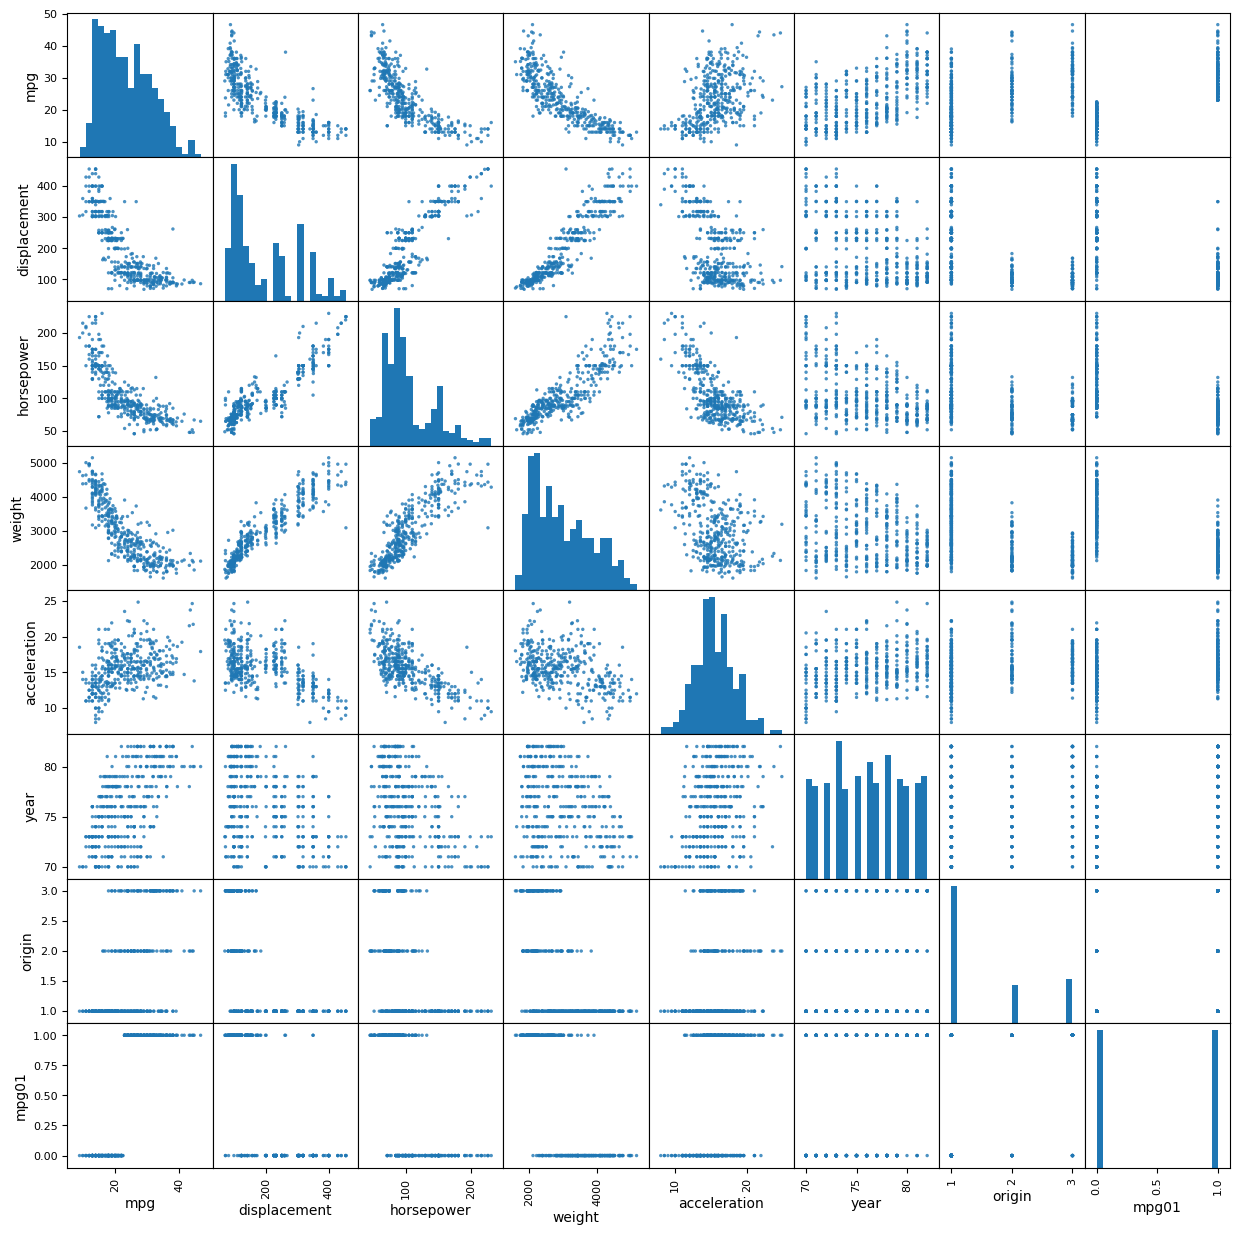

In [60]:
pd.plotting.scatter_matrix(auto, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=6, alpha=.8,
                           range_padding=0.2);

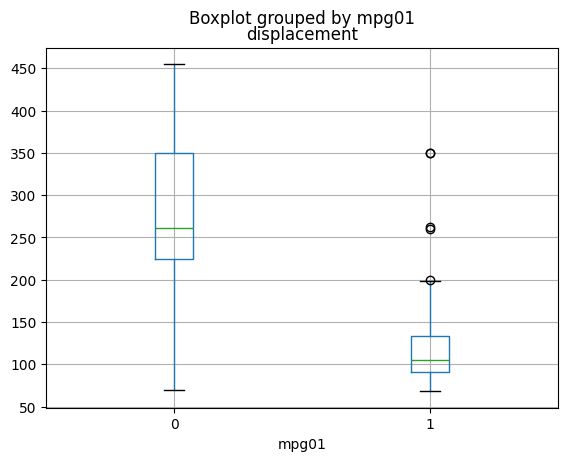

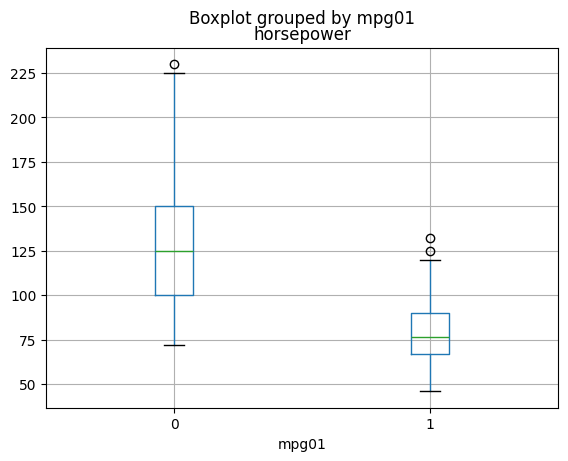

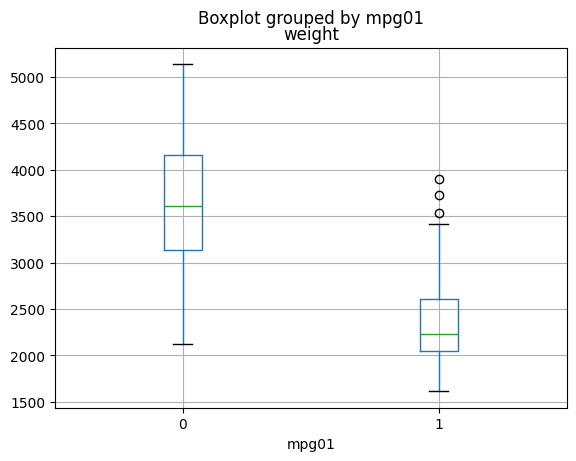

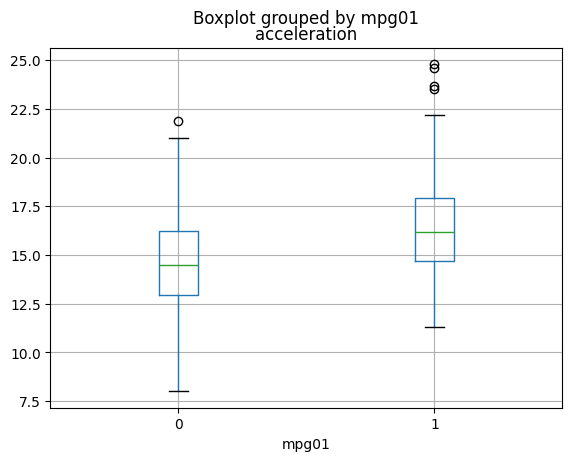

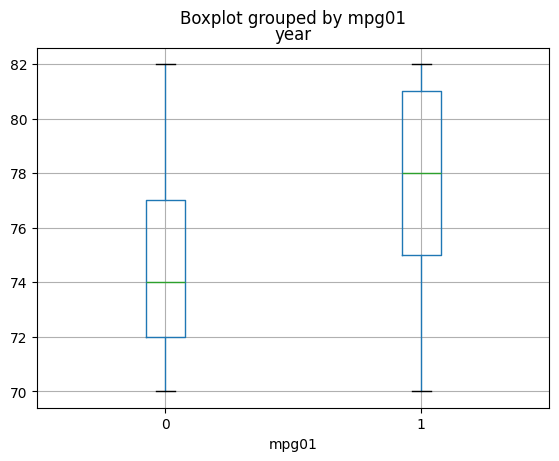

In [61]:
for i in range(2, 7):
    colName = auto.columns[i]
    auto.boxplot(column=colName, by="mpg01")

From these plots, we can assume that `displacement`, `horsepower`, `weight`, and maybe `year` could be good predictors for `mpg01`.

### 3) Build Training and Test Sets

Next, we'll split the `Auto` data into a training and test set.  We will again randomly select 85% of the data for our training set and the remaining 15% will be used as a test set.

NOTE: The small number of observations for 3 or 5 cylinders can be a problem here when splitting into a training and test set.  We've intentionally chosen a random split that has at least one observation of each number of cylinders in both the training and test set. Some code below will break if this in not ensured.

In [62]:
auto_train, auto_test = train_test_split(auto, random_state=4, test_size=0.15)

Next, we will construct `X` so we can fit a model using all of the variables (`cylinders`, `displacement`, `horsepower`, `weight`, and `year`) as predictors.  We will again use `MS()` and `fit_transform()` from `ISLP` to do so. 

In [63]:
allvars = auto.columns.drop(['mpg', 'origin', 'mpg01'])
design = MS(allvars)
X_train = design.fit_transform(auto_train)
X_test = design.fit_transform(auto_test)

Let's visualize `X` for this example by printing `X_train`.

In [64]:
X_train

,intercept,cylinders[4],cylinders[5],cylinders[6],cylinders[8],displacement,horsepower,weight,acceleration,year
name,,,,,,,,,,
ford futura,1.0,0.0,0.0,0.0,1.0,302.0,139,3205,11.2,78
chevrolet impala,1.0,0.0,0.0,0.0,1.0,350.0,165,4274,12.0,72
chevrolet impala,1.0,0.0,0.0,0.0,1.0,400.0,150,4997,14.0,73
chevrolet impala,1.0,0.0,0.0,0.0,1.0,454.0,220,4354,9.0,70
chevy c10,1.0,0.0,0.0,0.0,1.0,350.0,145,4055,12.0,76
...,...,...,...,...,...,...,...,...,...,...
ford granada gl,1.0,0.0,0.0,1.0,0.0,200.0,88,3060,17.1,81
dodge charger 2.2,1.0,1.0,0.0,0.0,0.0,135.0,84,2370,13.0,82
dodge aspen se,1.0,0.0,0.0,1.0,0.0,225.0,100,3651,17.7,76


Now we'll construct `y` (our response) which is the `mpg01` column in this example.  We'll again also create a version of `y` that contains labels `high` or `low` instead of `0` or `1`. 

In [65]:
y_train = auto_train.mpg01
y_test = auto_test.mpg01

L_train = auto_train['mpg01'].map({1: 'high', 0: 'low'})
L_test = auto_test['mpg01'].map({1: 'high', 0: 'low'})

### 4) Model Fitting, Prediction, and Evaluation

We will fit four types of models: Logistic Regression, Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and K-Nearest Neighbors (kNN).  We'll start by fitting and evaluating the full model under each of the four types.  Then, based on the full model results, we will fit a reduced model.

### Full Model


##### Logistic Regression - Full Model

Now let's try logistic regression.  Here's why we'll need `X_train` and `X_test` with the intercept columns.

In [66]:
glm_train = sm.GLM(y_train, X_train,
                  family = sm.families.Binomial())
results = glm_train.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  mpg01   No. Observations:                  333
Model:                            GLM   Df Residuals:                      323
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.008
Date:                Mon, 14 Jul 2025   Deviance:                       118.02
Time:                        11:43:06   Pearson chi2:                     174.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6433
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      -22.6905      7.449     -3.046      0.002     -37.290      -8.091
cylinders[4]     4.5832      1.704      2.690      0.007       1.243       7.923
cylinders[5]     2.1860      2.277      0.960      0.337      -2.276       6.648
cylinders[6]     3.1452      2.051      1.533      0.125      -0.875       7.166
cylinders[8]     7.2582      2.973      2.441      0.015       1.431      13.085
displacement    -0.0153      0.012     -1.233      0.218      -0.040       0.009
horsepower      -0.0517      0.028     -1.866      0.062      -0.106       0.003
weight          -0.0033      0.001     -2.722      0.006      -0.006      -0.001
acceleration    -0.1755      0.161     -1.093      0.274      -0.490       0.139
year             0.4989      0.099      5.062      0.000       0.306       0.692
================================================================================
"""

Now let's predict and evaluate.

In [67]:
probs = results.predict(exog=X_test)
labels = np.array(['high'] * L_test.shape[0])
labels[probs <= 0.5] = 'low'
confusion_table(labels, L_test)

Truth,high,low
Predicted,,
high,22,1
low,2,34


In [68]:
metrics_mpg = pd.DataFrame(np.zeros((2,4)), columns=["logistic", "lda", "qda", "knn1"],
                             index=["error_rate_full_mod", "error_rate_reduced_mod"])
metrics_mpg.loc['error_rate_full_mod', 'logistic'] = (1 + 2) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.0,0.0,0.0
error_rate_reduced_mod,0.000000,0.0,0.0,0.0


##### LDA - Full model

This time, we will start by fitting LDA via `LDA()` using all desired predictors.

In [69]:
lda = LDA(store_covariance=True)

We'll again remove the column corresponding to the intercept in both `X_train` and `X_test`, except this time we'll store them in new variables called `X_train2` and `X_test2` since we'll need the versions with the intercept later on.

In [70]:
X_train2, X_test2 = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]

Now we can fit, predict with, and evaluate the LDA model as we did in the previous exercise.

In [71]:
lda.fit(X_train, L_train)
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,high,low
Predicted,,
high,20,1
low,4,34


In [72]:
metrics_mpg.loc['error_rate_full_mod', 'lda'] = (1 + 4) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.0,0.0
error_rate_reduced_mod,0.000000,0.000000,0.0,0.0


It looks like LDA does a really good job of predicting `mpg01` under the full model, but logistic regression was better.

##### QDA - Full Model

Next let's try QDA.

In [73]:
qda = QDA(store_covariance=True)
qda.fit(X_train2, L_train)
qda_pred = qda.predict(X_test2)
confusion_table(qda_pred, L_test)

Truth,high,low
Predicted,,
high,21,1
low,3,34


In [74]:
metrics_mpg.loc['error_rate_full_mod', 'qda'] = (1 + 3) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.0
error_rate_reduced_mod,0.000000,0.000000,0.000000,0.0


QDA does just slightly better in that it correctly predicts one more `high` mpg car than LDA.

##### KNN - Full Model

Lastly, we'll try kNN with k=1 using our full list of predictors.  We again need to convert `X_train` and `X_test` to array.

In [75]:
X_train_arr, X_test_arr = [np.asarray(M)
                   for M in [X_train, X_test]]
knn1 = KNN(n_neighbors=1)
knn1.fit(X_train_arr, L_train)
knn1_pred = knn1.predict(X_test_arr)
confusion_table(knn1_pred, L_test)

Truth,high,low
Predicted,,
high,19,4
low,5,31


In [76]:
metrics_mpg.loc['error_rate_full_mod', 'knn1'] = (4 + 5) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.152542
error_rate_reduced_mod,0.000000,0.000000,0.000000,0.000000


We didn't do as well with kNN (`k=1`). 

### Reduced Model

Now let's try just using three predictors: `displacement`, `weight`, `horsepower`. Let's reconstruct the design.

##### Logistic Regression - Reduced Model

Next let's try logistic regression.

In [77]:
design = MS(['displacement', 'weight', 'horsepower'])
X_train = design.fit_transform(auto_train)
X_test = design.fit_transform(auto_test)

In [78]:
glm_train = sm.GLM(y_train, X_train,
                  family = sm.families.Binomial())
results = glm_train.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  mpg01   No. Observations:                  333
Model:                            GLM   Df Residuals:                      329
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.957
Date:                Mon, 14 Jul 2025   Deviance:                       179.91
Time:                        11:43:24   Pearson chi2:                     509.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5704
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       11.7072      1.706      6.861      0.000       8.363      15.052
displacement    -0.0116      0.006     -2.006      0.045      -0.023      -0.000
weight          -0.0022      0.001     -2.931      0.003      -0.004      -0.001
horsepower      -0.0361      0.014     -2.525      0.012      -0.064      -0.008
================================================================================
"""

In [79]:
probs = results.predict(exog=X_test)
labels = np.array(['high'] * L_test.shape[0])
labels[probs <= 0.5] = 'low'
confusion_table(labels, L_test)

Truth,high,low
Predicted,,
high,21,3
low,3,32


In [80]:
metrics_mpg.loc['error_rate_reduced_mod', 'logistic'] = (3 + 3) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.152542
error_rate_reduced_mod,0.101695,0.000000,0.000000,0.000000


##### LDA - Reduced Model

We'll start with LDA again and droping the intercept from `X_train` and `X_test`.

In [81]:
lda = LDA(store_covariance=True)
X_train2, X_test2 = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train2, L_train)
lda_pred = lda.predict(X_test2)
confusion_table(lda_pred, L_test)

Truth,high,low
Predicted,,
high,21,4
low,3,31


In [82]:
metrics_mpg.loc['error_rate_reduced_mod', 'lda'] = (4 + 3) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.152542
error_rate_reduced_mod,0.101695,0.118644,0.000000,0.000000


##### QDA - Reduced Model

Now let's try QDA using our reduced number of predictors.

In [83]:
qda = QDA(store_covariance=True)
qda.fit(X_train2, L_train)
qda_pred = qda.predict(X_test2)
confusion_table(qda_pred, L_test)

Truth,high,low
Predicted,,
high,21,3
low,3,32


In [84]:
metrics_mpg.loc['error_rate_reduced_mod', 'qda'] = (3 + 3) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.152542
error_rate_reduced_mod,0.101695,0.118644,0.101695,0.000000


##### KNN - Reduced Model

Lastly let's try KNN.

In [85]:
X_train_arr, X_test_arr = [np.asarray(M)
                   for M in [X_train, X_test]]
knn1 = KNN(n_neighbors=1)
knn1.fit(X_train_arr, L_train)
knn1_pred = knn1.predict(X_test_arr)
confusion_table(knn1_pred, L_test)

Truth,high,low
Predicted,,
high,18,4
low,6,31


In [86]:
metrics_mpg.loc['error_rate_reduced_mod', 'knn1'] = (4 + 6) / L_test.shape[0]
metrics_mpg

,logistic,lda,qda,knn1
error_rate_full_mod,0.050847,0.084746,0.067797,0.152542
error_rate_reduced_mod,0.101695,0.118644,0.101695,0.169492


Overall, we do worse with the reduced model but not by that much.  Given that overfitting could be a concern with the full model, it may make more sense to use the reduced model.